In [1]:
import autograd.numpy as np

class Adam:
    def __init__(self, num_params, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):        
        self.lr = lr                
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.it_cnt = 0        
        self.mt = np.zeros(num_params)     
        self.vt = np.zeros(num_params)  
        
    def step(self, w, grad_w):        
        self.it_cnt = self.it_cnt + 1        
        self.mt = self.mt*self.beta1 + (1.0-self.beta1)*grad_w
        self.vt = self.vt*self.beta2 + (1.0-self.beta2)*grad_w**2
        mt_hat = self.mt/(1.0-self.beta1**self.it_cnt)
        vt_hat = self.vt/(1.0-self.beta2**self.it_cnt)
        w = w - (self.lr/(np.sqrt(vt_hat) + self.epsilon))*mt_hat            
        return w

In [2]:
import autograd.numpy as np
from autograd import grad

class LinearRegression:
    """
    Linear regression model: y = (w.T)*x + \epsilon
    p(y|x,theta) ~ N(y|(w.T)*x, sigma^2), theta = (w, sigma^2)
    """
  # Initialize model class
    def __init__(self, X, y, M):
        
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.M = M

        # Randomly initialize weights and noise variance
        w = np.random.randn(2*self.M, y.shape[1])
        sigma_sq = np.random.randn(1, 1)

        # Concatenate all parameters in a single vector
        self.theta = np.concatenate([w.flatten(), sigma_sq.flatten()])

        # Count total number of parameters
        self.num_params = self.theta.shape[0]

        # Define loss gradient function using autograd
        self.grad_loss = grad(self.loss)
        
        #store the loss and # of iterations
        self.loss_log = []
        self.iterations = []
        
  # Evaluates the forward prediction of the model
    def forward_pass(self, w):
        y = np.matmul(self.Phi, w)
        return y

  # Evaluates the negative log-marginal likelihood loss, i.e. -log p(y|x,theta)
    def loss(self, theta): 
        X = self.X_batch
        y = self.y_batch
        # Fetch individual parameters from the theta vector and reshape if needed
        w = np.reshape(theta[:-1],(2*self.M, self.y.shape[1]))
        sigma_sq = theta[-1]**2
        # Compute features
        self.Phi = self.get_Fourier_basis(X)
        # Evaluate the model's prediction
        y_pred = self.forward_pass(w)
        # Compute the loss
        NLML = 0.5*self.batch_size*np.log(2.0 * np.pi*sigma_sq) + 0.5/sigma_sq*np.dot(np.transpose(y - y_pred), (y-y_pred))
        
        #0.5 * self.n * np.log(2.0*np.pi*sigma_sq) + \
         #    0.5 * (np.sum(y - y_pred)**2) / sigma_sq
        return NLML
    
    # Fetches a mini-batch of data
    def fetch_minibatch(self, X, Y, N_batch):
        idx = np.random.choice(self.n, N_batch, replace=False)
        X_batch = X[idx,:]
        Y_batch = Y[idx,:]
        return X_batch, Y_batch
    
  # Given an optimizer, trains the model for a number of steps      
    def train(self, num_steps, optimizer, batch_size = 64):
        self.batch_size = batch_size
        for it in range(0, num_steps):
          # Evaluate loss using current parameters
            self.X_batch, self.y_batch = self.fetch_minibatch(self.X, self.y, batch_size)
            theta = self.theta
            loss = self.loss(theta)
            if it % 100 == 0:
                self.loss_log.append(loss)
                self.iterations.append(it)
#                print("Iteration: %d, loss: %.3e" % (it, loss))

            # Update parameters
            grad_theta = self.grad_loss(theta)
            self.theta = optimizer.step(theta, grad_theta)
        
        #Store the loss function
        self.iterations = np.asarray(self.iterations)
        self.loss_log = np.asarray(self.loss_log)
        self.loss_log = np.reshape(self.loss_log, (self.iterations.shape[0], 1))

    def predict(self, X_star):
        Phi = self.get_Fourier_basis(X_star)
        w = np.reshape(self.theta[:-1],(2*self.M, self.y.shape[1]))
        y_pred = np.matmul(Phi, w)
        return y_pred

    # Fourier features
    def get_Fourier_basis(self, X):
        N = X.shape[0]
        output = np.zeros((N,2*M))
        for i in range(M):
            output[:,2*i:2*i+1] = np.sin(i*np.pi*X)
            output[:,2*i+1:2*i+2] = np.cos(i*np.pi*X)
        return output   

In [3]:
#Problem 1
import matplotlib.pyplot as plt
from pyDOE import lhs

if __name__ == "__main__": 
    
    def f(x):
        return 2.0*np.sin(2.0*np.pi*x) + np.sin(8.0*np.pi*x) + 0.5*np.sin(16.0*np.pi*x)
    
    # N is the number of training points.
    N = 500
    noise_var = 0.2
    lb = -1.0
    ub = 1.0
    
    # Training data
    X = lb + (ub-lb)*lhs(1, N)
    y = f(X)
    y = y + noise_var*np.std(y)*np.random.randn(N,1)
    
    # Test data
    X_star = np.linspace(lb, ub, 1000)[:,None]
    y_star = f(X_star)
       
    # Define model
    M = 16
    basis = 'Fourier'
    model = LinearRegression(X, y, M)
       
    # Define an optimizer
    optimizer = Adam(model.num_params, lr = 1e-3)
    
    # Train the model
    model.train(10000, optimizer, batch_size = 64)
    
    
    # Make predictions
    y_pred = model.predict(X_star)
    
    # Compute relative error
    error = np.linalg.norm(y_star-y_pred, 2)/np.linalg.norm(y_star, 2)
    print('Relative L2 error: %e' % (error))
    
    # Plot
    plt.figure(1, figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(X_star, y_star, linewidth = 3, label = 'Exact')
    plt.plot(X_star, y_pred,'r',linewidth = 1, label = 'Prediction')
    plt.plot(X, y, 'o', alpha = 0.2, label = 'Training data')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(model.iterations, model.loss_log,  linewidth = 2, label = 'Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

Relative L2 error: 2.235432e-01


<Figure size 1200x600 with 2 Axes>

As the basis is Fourier series, the funciton involve the sin(16pi*x). The minimum M we want to use is 17. The above result is for batch size = 64.

Relative L2 error: 2.311209e-01


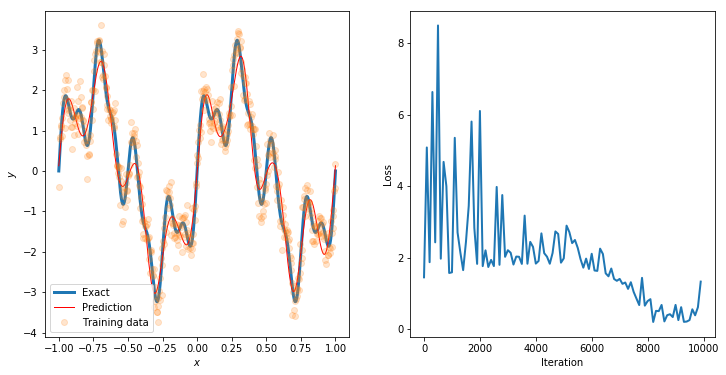

In [4]:
model = LinearRegression(X, y, M)

# Define an optimizer
optimizer = Adam(model.num_params, lr = 1e-3)

# Train the model
model.train(10000, optimizer, batch_size = 1)


# Make predictions
y_pred = model.predict(X_star)

# Compute relative error
error = np.linalg.norm(y_star-y_pred, 2)/np.linalg.norm(y_star, 2)
print('Relative L2 error: %e' % (error))

# Plot
plt.figure(2, figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(X_star, y_star, linewidth = 3, label = 'Exact')
plt.plot(X_star, y_pred,'r',linewidth = 1, label = 'Prediction')
plt.plot(X, y, 'o', alpha = 0.2, label = 'Training data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.iterations, model.loss_log,  linewidth = 2, label = 'Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Relative L2 error: 2.226041e-01


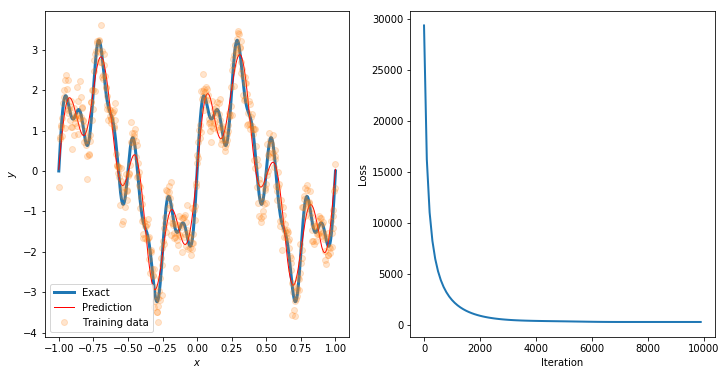

In [5]:
model = LinearRegression(X, y, M)

# Define an optimizer
optimizer = Adam(model.num_params, lr = 1e-3)

# Train the model
model.train(10000, optimizer, batch_size = N)


# Make predictions
y_pred = model.predict(X_star)

# Compute relative error
error = np.linalg.norm(y_star-y_pred, 2)/np.linalg.norm(y_star, 2)
print('Relative L2 error: %e' % (error))

# Plot
plt.figure(3, figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(X_star, y_star, linewidth = 3, label = 'Exact')
plt.plot(X_star, y_pred,'r',linewidth = 1, label = 'Prediction')
plt.plot(X, y, 'o', alpha = 0.2, label = 'Training data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.iterations, model.loss_log,  linewidth = 2, label = 'Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

The above results are for batch size = 1 and batch size = full size.

Note that the loss we are giving is the loss function computed over the mini-batch which is different from the full batch loss. In this case, we would see the the loss is oscillating a lot for small mini-batch.

For large batch size, we can use a big learning rate. For small batch size, we need to use a small learning rate to carefully update the parameters.

In [6]:
#Problem 2

In [7]:
import autograd.numpy as np
import itertools
import matplotlib.pyplot as plt

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [8]:
class LogisticRegression:
    # Initialize model class
    def __init__(self, X, y):
      
        self.X = X
        self.y = y
        self.n = X.shape[0]

        # Randomly initialize weights and noise variance
        w = np.random.randn(X.shape[1], y.shape[1])

        # Concatenate all parameters in a single vector
        self.theta = np.concatenate([w.flatten()])

        # Count total number of parameters
        self.num_params = self.theta.shape[0]

        # Define loss gradient function using autograd
        self.grad_loss = grad(self.loss)

        #store the loss and # of iterations
        self.loss_log = []
        self.iterations = []
        
    # Fetches a mini-batch of data
    def fetch_minibatch(self, X, Y, N_batch):
        idx = np.random.choice(self.n, N_batch, replace=False)
        X_batch = X[idx,:]
        Y_batch = Y[idx,:]
        return X_batch, Y_batch
  
    # Evaluates the negative log-marginal likelihood loss, i.e. -log p(y|x,theta)
    def loss(self, theta): 
        X = self.X_batch
        y = self.y_batch
        # Fetch individual parameters from the theta vector and reshape if needed
        w = np.reshape(theta,(X.shape[1], 1))
        # Evaluate the model's prediction
        logits = np.matmul(X, w)
        y_pred = self.sigmoid(logits)
        # Compute the loss
        loss  = -np.sum(y*np.log(y_pred+1e-8) + (1.0-y)*np.log(1.0-y_pred+1e-8))
        return loss
        
    # Given an optimizer, trains the model for a number of steps      
    def train(self, num_steps, optimizer, batch_size = 64):
        for it in range(0, num_steps):
            # Fetch minibatch
            self.X_batch, self.y_batch = self.fetch_minibatch(self.X, self.y, batch_size)
            # Evaluate loss using current parameters
            theta = self.theta
            loss = self.loss(theta)
            if it % 1000 == 0:
                self.loss_log.append(loss)
                self.iterations.append(it)
                print("Iteration: %d, loss: %.3e" % (it, loss))

            # Stochastic gradient descent update
            grad_theta = self.grad_loss(theta)
            self.theta = optimizer.step(theta, grad_theta)

        #Store the loss function
        self.iterations = np.asarray(self.iterations)
        self.loss_log = np.asarray(self.loss_log)
        self.loss_log = np.reshape(self.loss_log, (self.iterations.shape[0], 1))


          
    def predict(self, X_star):
        w = np.reshape(self.theta,(self.X.shape[1], 1))
        y_pred = self.sigmoid(np.matmul(X_star, w))
        return y_pred
  
    # Logistic sigmoid function
    def sigmoid(self, x):
        return 0.5*(np.tanh(x) + 1.0)

Iteration: 0, loss: 2.919e+02
Iteration: 1000, loss: 6.444e+01
Iteration: 2000, loss: 2.908e+01
Iteration: 3000, loss: 1.904e+01
Iteration: 4000, loss: 1.662e+01
Iteration: 5000, loss: 1.946e+01
Iteration: 6000, loss: 1.882e+01
Iteration: 7000, loss: 1.852e+01
Iteration: 8000, loss: 1.271e+01
Iteration: 9000, loss: 1.747e+01
Iteration: 10000, loss: 1.994e+01
Iteration: 11000, loss: 1.546e+01
Iteration: 12000, loss: 1.320e+01
Iteration: 13000, loss: 1.703e+01
Iteration: 14000, loss: 1.296e+01
Iteration: 15000, loss: 1.594e+01
Iteration: 16000, loss: 1.407e+01
Iteration: 17000, loss: 8.335e+00
Iteration: 18000, loss: 1.660e+01
Iteration: 19000, loss: 1.229e+01
Classification accuracy: 0.790%


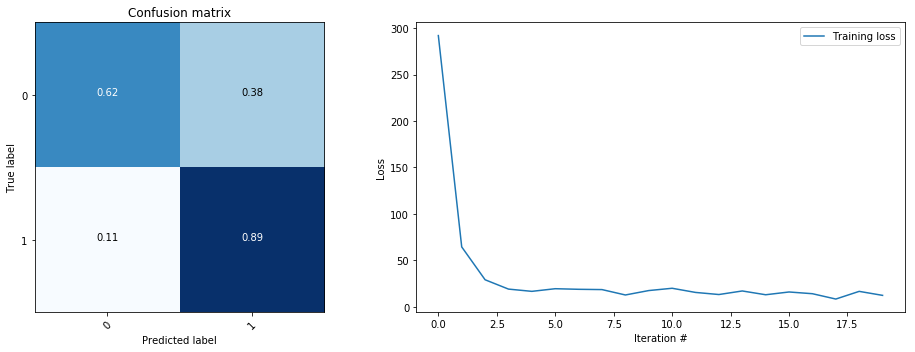

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


if __name__ == "__main__": 
    
    # Load data
    data = pd.read_csv('ElectricalGridData.csv')
    features = data.values[:,:-2]
    labels = data.values[:,-1]
    
    n_classes = 2
    
    # Convert to binary labels
    idx_stable = (labels == 'stable')
    idx_unstable = (labels == 'unstable')
    labels[idx_stable] = 0
    labels[idx_unstable] = 1
    
    # Training data 
    N = features.shape[0] + 1
    x =  np.ones((features.shape[0], 1))
    features = np.hstack((x, features))
    N_train = int(N * (2.0/3.0))
    X_train = features[0:N_train, :].astype('float32')
    y_train = labels[0:N_train][:,None].astype('int8')

    # Test data
    X_test = features[N_train:, :].astype('float32')
    y_test = labels[N_train:][:,None].astype('int8')
    
    # Define model
    model = LogisticRegression(X_train, y_train)
    optimizer = Adam(model.num_params, lr = 1e-3)
    
    # Train the model
    model.train(20000, optimizer, batch_size = 32)
    
    # Prediction
    test_pred = model.predict(X_test)
    test_labels = np.around(test_pred, decimals = 0)
    
    # Compute confusion matrix
    M = confusion_matrix(y_test, test_labels)
    
    # False positives, False negatives, True positives, True negatives
    FP = M.sum(axis=0) - np.diag(M)  
    FN = M.sum(axis=1) - np.diag(M)
    TP = np.diag(M)
    TN = M.sum() - (FP + FN + TP)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print('Classification accuracy: %.3f%%' % (ACC.mean(0)))
    
    # Plotting
    plt.figure(1, figsize=(14,5))
    plt.subplot(1,2,1)
    plot_confusion_matrix(M, classes=np.arange(2), normalize=True)
    plt.subplot(1,2,2)
    plt.plot(model.loss_log, label = 'Training loss')
    plt.legend()
    plt.xlabel('Iteration #')
    plt.ylabel('Loss')
    plt.show()
    